<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Course Rating Prediction using Neural Networks**


Estimated time needed: **60** minutes


In the previous labs, we have crafted several types of user and item feature vectors.  For example, given a user `i`, we may build its profile feature vector and course rating feature vector, and given an item `j`, we may create its genre vector and user enrollment vectors.



With these explicit features vectors, we can perform machine learning tasks such as calculating the similarities among users or items, finding nearest neighbors, and using dot-product to estimate a rating value. 

The main advantage of using these explicit features is they are highly interpretable and yield very good performance as well. The main disadvantage is we need to spend quite some effort to build and store them.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/explicit_user_item_features.png)


Is it possible to predict a rating without building explicit feature vectors beforehand?  

Yes, as you may recall, the Non-negative Matrix Factorization decomposes the user-item interaction matrix into user matrix and item matrix, which contain the latent features of users and items and you can simply dot-product them to get an estimated rating.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/nmf.png)


In addition to NMF, neural networks can also be used to extract the latent user and item features?  In fact,  neural networks are very good at learning patterns from data and are widely used to extract latent features.  When training neural networks, it gradually captures and stores the features within its hidden layers as weight matrices and can be extracted to represent the original data.


In this lab, you will be training neural networks to predict course ratings while simultaneously extracting users' and items' latent features. 


## Objectives


After completing this lab you will be able to:


* Use `tensorflow` to train neural networks to extract the user and item latent features from the hidden's layers  
* Predict course ratings with trained neural networks


----


## Prepare and setup lab environment


Install tensorflow 2.7 if not installed before in your Python environment


In [1]:
#!pip install tensorflow==2.7.0

and import required libraries:


In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# also set a random state
rs = 123

### Load and processing rating dataset


In [4]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


This is the same rating dataset we have been using in previous lab, which contains the three main columns: `user`, `item`, and `rating`. 


Next, let's figure out how many unique users and items, their total numbers will determine the sizes of one-hot encoding vectors.


In [5]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


It means our each user can be represented as a `33901 x 1` one-hot vector and each item can be represented as `126 x 1` one-hot vector.


The goal is to create a neural network structure that can take the user and item one-hot vectors as inputs and outputs a rating estimation or the probability of interaction (such as the probability of completing a course). 

While training and updating the weights in the neural network, its hidden layers should be able to capture the pattern or features for each user and item. Based on this idea, we can design a simple neural network architecture like the following:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/embedding_feature_vector.png)


The network inputs are two one-hot encoding vectors, the blue one is for the user and the green one is for the item. Then on top of them, we added two embedding layers. Here embedding means embedding the one-hot encoding vector into a latent feature space. The embedding layer is a fully-connected layer that outputs the embedding feature vectors. For example, the user embedding layer takes `33901 x 1` one-hot vector as input and outputs a `16 x 1` embedding vector.


The embedding layer outputs two embedding vectors, which are similar to Non-negative matrix factorization. Then we could simply dot the product the user and item embedding vector to output a rating estimation.


#### Implementing the recommender neural network using tensorflow 


This network architecture could be defined and implemented as a sub-class inheriting the `tensorflow.keras.Model` super class, let's call it `RecommenderNet()`.


In [6]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)

### TASK: Train and evaluate the RecommenderNet()


Now it's time to train and evaluate the defined `RecommenderNet()`. First, we need to process the original rating dataset a little bit by converting the actual user ids and item ids into integer indices for `tensorflow` to creating the one-hot encoding vectors.


In [7]:
def process_dataset(raw_data):
    
    encoded_data = raw_data.copy()
    
    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [8]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [9]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


Then we can split the encoded dataset into training and testing datasets.


In [10]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [11]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

If we take a look at the training input data, it is simply just a list of user indices and item indices, which is a dense format of one-hot encoding vectors.


In [12]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973])

In [13]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17])

and training output labels are a list of 0s and 1s indicating if the user has completed a course or not.


In [14]:
y_train

array([1., 1., 1., ..., 1., 0., 1.])

Then we can choose a small embedding vector size to be 16 and create a `RecommenderNet()` model to be trained


In [15]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

_TODO: Train the RecommenderNet() model_


Epoch 1/10


2024-04-24 19:53:30.504534: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-24 19:53:30.504559: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-04-24 19:53:30.504566: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-04-24 19:53:30.504592: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-24 19:53:30.504600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-04-24 19:53:30.769312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2917/2917 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.2955 - root_mean_squared_error: 0.5160 - val_loss: 0.0407 - val_root_mean_squared_error: 0.2005
Epoch 2/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.0416 - root_mean_squared_error: 0.2017 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1857
Epoch 3/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - loss: 0.0285 - root_mean_squared_error: 0.1664 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1576
Epoch 4/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.0215 - root_mean_squared_error: 0.1431 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1470
Epoch 5/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.0173 - root_mean_squared_error: 0.1269 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1393
Epoch 6/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.0150 - root_mean_squared_error: 0.1168 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1357
Epoch 7/10
2917/2917 ━━━━━━━━━━━━━━━━━━

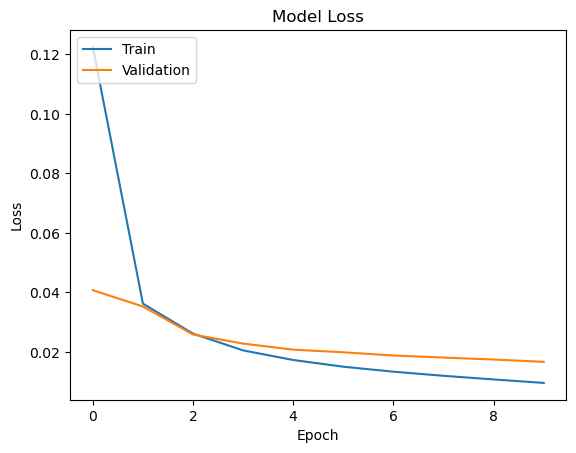

In [16]:
## WRITE YOUR CODE HERE:

## - call model.compile() method to set up the loss and optimizer and metrics for the model training, you may use
##  - - tf.keras.losses.MeanSquaredError() as training loss
##  - - keras.optimizers.Adam() as optimizer
##  - - tf.keras.metrics.RootMeanSquaredError() as metric

## - call model.fit() to train the model

## - optionally call model.save() to save the model

## - plot the train and validation loss


model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

model.save("recommender_model.keras")

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

<details>
    <summary>Click here for Hints</summary>
    
When you are fitting a model, dont forget to specify the parameters: `x=x_train, y=y_train`, as well as `batch_size=64`, number of `epochs=10` and of course `validation_data=(x_val, y_val)` you can also define `verbose = 1` which will show you an animated progress for the training progress for each epoch.
    
* You can set  `history = model.fit()` which will give you a "loss" dataframe which will be very useful for ploting the train and validation loss. To plot it, use plt.plot() with `history.history["loss"]` as its parameter for train loss and `history.history["val_loss"]` for validation loss.


_TODO:_ Evaluate the trained model


In [17]:
### WRITE YOUR CODE HERE

### - call model.evaluate() to evaluate the model

test_loss, test_rmse = model.evaluate(x_test, y_test)
print(f"Test RMSE: {test_rmse:.3f}")

730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0164 - root_mean_squared_error: 0.1211
Test RMSE: 0.120


<details>
    <summary>Click here for Hints</summary>
    
Use `x_test, y_test` as parameters for `model.evaluate()`


### Extract the user and item embedding vectors as latent feature vectors


Now, we have trained the `RecommenderNet()` model and it can predict the ratings with relatively small RMSE. 

If we print the trained model then we can see its layers and their parameters/weights.


In [18]:
model.summary()

Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding_layer            │ ?                      │       542,416 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ user_bias (Embedding)           │ ?                      │        33,901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding_layer            │ ?                      │         2,016 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_bias (Embedding)           │ ?                      │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,735,379 (6.62 MB)

 Trainable params: 578,459 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,156,920 (4.41 MB)

In the `RecommenderNet`, the `user_embedding_layer` and `item_embedding_layer` layers contain the trained weights. Essentially, they are the latent user and item features learned by `RecommenderNet` and will be used to predict the interaction. As such, while training the neural network to predict rating, the embedding layers are simultaneously trained to extract the embedding user and item features.


We can easily get the actual weights using `model.get_layer().get_weights()` methods


In [19]:
# User features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 16)


In [20]:
user_latent_features[0]

array([ 0.11828271, -0.02045443,  0.05312572, -0.08994304, -0.05234556,
        0.02444591, -0.06040223, -0.00457138,  0.07262315, -0.00524663,
        0.08423786,  0.03767432,  0.04500301, -0.00569072,  0.04677116,
        0.00637686], dtype=float32)

In [21]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 16)


In [22]:
item_latent_features[0]

array([ 0.00939607, -0.01032383, -0.01606383,  0.00407156,  0.01223269,
        0.01344558,  0.01951298,  0.00201074,  0.008434  , -0.02356732,
       -0.00062318, -0.00106937, -0.00072265,  0.00171911,  0.01654263,
        0.01269671], dtype=float32)

Now, each user of the total 33901 users has been transformed into a 16 x 1 latent feature vector and each item of the total 126 has been transformed into a 16 x 1 latent feature vector.


### TASK (Optional): Customize the RecommenderNet to potentially improve the model performance


The pre-defined `RecommenderNet()` is a actually very basic neural network, you are encouraged to customize it to see if model prediction performance will be improved. Here are some directions:
- Hyperparameter tuning, such as the embedding layer dimensions
- Add more hidden layers
- Try different activation functions such as `ReLu`


In [23]:
## WRITE YOUR CODE HERE

## Update RecommenderNet() class

## compile and fit the updated model

## evaluate the updated model

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size=16, hidden_layers=[32, 16], activation='relu', **kwargs):
        """
        Constructor
        :param int num_users: number of users
        :param int num_items: number of items
        :param int embedding_size: the size of embedding vector
        :param list hidden_layers: list of integers representing the dimensions of hidden layers
        :param str activation: activation function to use in hidden layers
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.hidden_layers = hidden_layers
        self.activation = activation

        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")

        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")

        # Define hidden layers
        self.hidden_dense_layers = [layers.Dense(units, activation=activation) for units in hidden_layers]

        # Output layer
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        """
        method to be called during model fitting
        :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])

        dot_user_item = tf.tensordot(user_vector, item_vector, 2)

        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias

        # Pass through hidden layers
        for dense_layer in self.hidden_dense_layers:
            x = dense_layer(x)

        # Output layer
        output = self.output_layer(x)
        return output

Epoch 1/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - auc: 0.8155 - binary_accuracy: 0.9597 - loss: 0.1814 - root_mean_squared_error: 0.2195 - val_auc: 0.9316 - val_binary_accuracy: 0.9668 - val_loss: 0.1028 - val_root_mean_squared_error: 0.1640
Epoch 2/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - auc: 0.9066 - binary_accuracy: 0.9618 - loss: 0.1186 - root_mean_squared_error: 0.1756 - val_auc: 0.9537 - val_binary_accuracy: 0.9691 - val_loss: 0.0896 - val_root_mean_squared_error: 0.1548
Epoch 3/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - auc: 0.9569 - binary_accuracy: 0.9704 - loss: 0.0866 - root_mean_squared_error: 0.1522 - val_auc: 0.9700 - val_binary_accuracy: 0.9747 - val_loss: 0.0737 - val_root_mean_squared_error: 0.1403
Epoch 4/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - auc: 0.9781 - binary_accuracy: 0.9786 - loss: 0.0628 - root_mean_squared_error: 0.1284 - val_auc: 0.9690 - val_binary_accuracy: 0.9773 - val_loss: 0.0707 - val_root_mean_squared_error: 0.1332


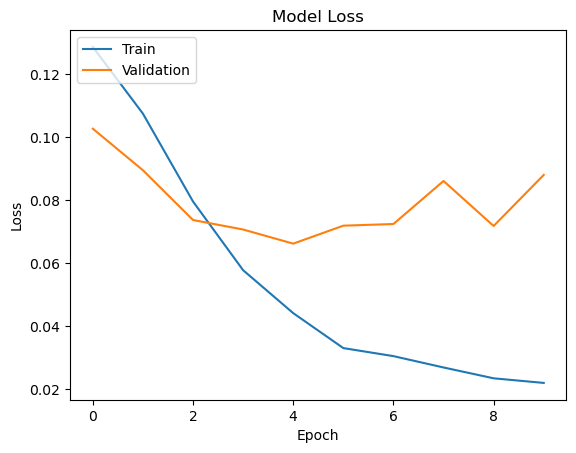

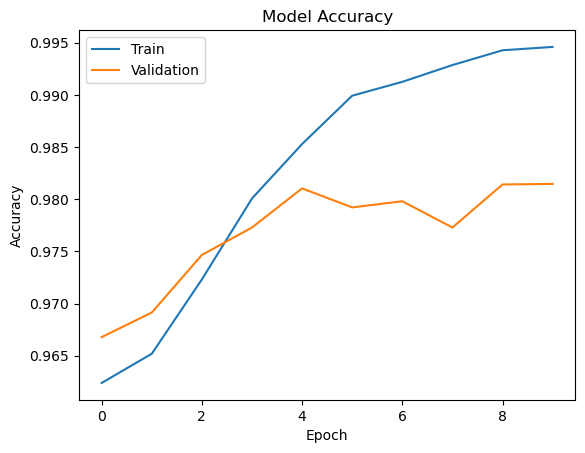

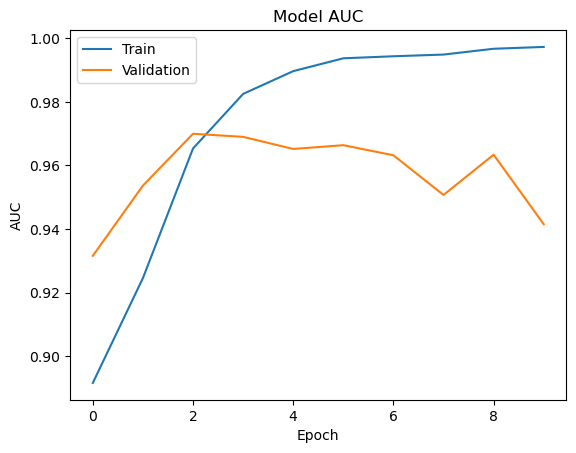

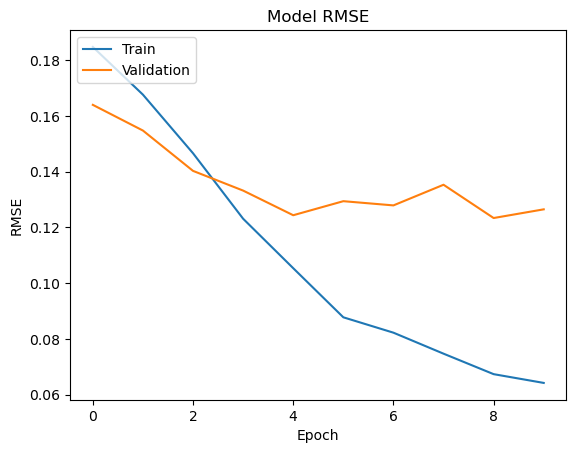

In [24]:
import matplotlib.pyplot as plt
from keras.metrics import RootMeanSquaredError

# Create an instance of the model
model = RecommenderNet(num_users, num_items, embedding_size=32, hidden_layers=[64, 32], activation='relu')

# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(name='auc'), RootMeanSquaredError()]
)

# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_split=0.1,
)

# Evaluate the model on the test set
test_loss, test_accuracy, test_auc, test_rmse = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test AUC:", test_auc)
print("Test RMSE:", test_rmse)

# Plot the training and validation loss curves
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Plot the training and validation accuracy curves
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Plot the training and validation AUC curves
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.title("Model AUC")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Plot the training and validation RMSE curves
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("Model RMSE")
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [25]:
model.summary()

Model: "recommender_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding_layer            │ ?                      │     1,084,832 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ user_bias (Embedding)           │ ?                      │        33,901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding_layer            │ ?                      │         4,032 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_bias (Embedding)           │ ?                      │           126 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,375,398 (12.88 MB)

 Trainable params: 1,125,132 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,250,266 (8.58 MB)

### Summary


In this lab, you have learned and practiced predicting course ratings using neural networks. With a predefined and trained neural network, we can extract or embed users and items into latent feature spaces and further predict the interaction between a user and an item with the latent feature vectors.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01)


### Other Contributors


## Change Log


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2021-10-25|1.0|Yan|Created the initial version|


Copyright © 2021 IBM Corporation. All rights reserved.
